In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import bayesian_pdes as bpdes
import sympy as sp
import numpy as np
from scipy import stats
import mcmc
%load_ext mcmc
%mcmc notebook

In [2]:
x,y = sp.symbols('x y')
sigma = 0.1
k = sp.exp(-(x-y)**2 / (2*sigma**2))

A = lambda k: k.diff(x,x)
Abar = lambda k: k.diff(y,y)
B = lambda k: k
Bbar = B

ops = [A,B]
ops_bar = [Abar, Bbar]

op_cache = bpdes.operator_caching.generate_op_cache(ops, ops_bar, k, [[x], [y]])

In [3]:
collocate_points = np.linspace(0,1,21)[1:-1, None]
bdy_points = np.array([[0.], [1.]])
bdy_vals = np.array([[0.], [0.]])
data_points = np.linspace(0,1,11)[1:-1, None]
#data_vals = -np.sin(2*np.pi*data_points) / (4*np.pi**2)
data_vals = 0.5*(data_points**2 - data_points)

In [4]:
discretisation_points = collocate_points
n_discretisation = len(discretisation_points)

In [5]:
class NamedLambda(object):
    def __init__(self, func, desc):
        self.__func__ = func
        self.__desc__ = desc
    def __call__(self, *args):
        return self.__func__(*args)
    def __str__(self):
        return '<NamedLambda: {}>'.format(self.__desc__)
    def __repr__(self):
        return '<NamedLambda: {}>'.format(self.__desc__)

In [6]:
likelihood_sigma = 0.01

# Parametric RHS

Here we are trying to solve:

$$
\nabla ^2 u = \lambda \\
u = 0\\
D = [0,1] \\
$$

True data is $\lambda = 1$. This has solution $\frac{\lambda}{2} (x^2 + x)$

Initially we supply the information that the RHS is parametric and just try to infer that single parameter with RWM.

## Setup

In [7]:
def get_posterior(theta):
    rhs = theta * np.ones_like(collocate_points)
    obs = [(collocate_points, rhs), (bdy_points, bdy_vals)]
    
    posterior = bpdes.collocate(ops, ops_bar, None, None, obs, op_cache)
    return posterior

def log_likelihood(theta):
    posterior = get_posterior(theta)
    mu, cov = posterior(data_points)
    log_lik = stats.multivariate_normal.logpdf(mu.ravel(), data_vals.ravel(), cov + likelihood_sigma**2*np.eye(cov.shape[0]))
    return log_lik

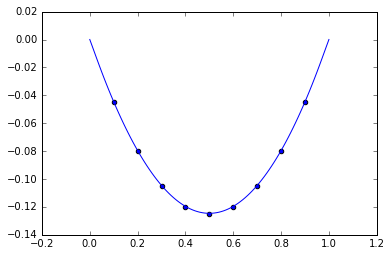

In [8]:
post = get_posterior(1)
test_points = np.linspace(0,1,101)[:,None]
mu, cov = post(test_points)
plt.plot(test_points, mu)
plt.scatter(data_points, data_vals)

## Plot Likelihood

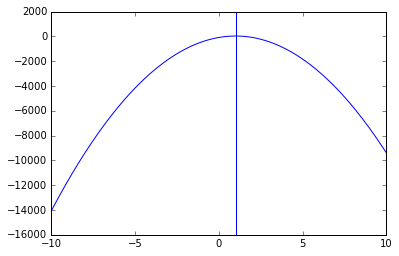

In [9]:
test_points = np.linspace(-10,10,200)
ll = np.array([log_likelihood(p) for p in test_points])
plt.plot(test_points, ll)
plt.axvline(1)

# Run MCMC

In [10]:
def proposal(theta):
    return theta + np.random.normal(0, proposal_sigma)

In [11]:
proposal_sigma = 0.2
samples = mcmc.rwm(5000, proposal, log_likelihood, lambda theta: 0., 1.0)

In [12]:
burn = 1000
thin = 1
thinned_burned = samples[burn:-1:thin, :]

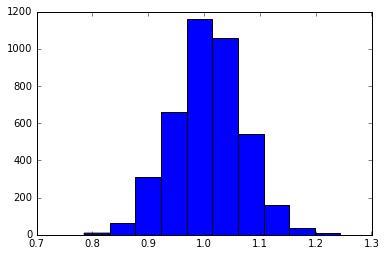

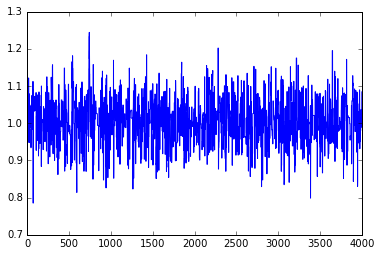

In [13]:
plt.hist(thinned_burned)
plt.figure()
plt.plot(thinned_burned)

# Nonparametric RHS

Now let's look at:

$$
\nabla^2 u = \kappa(x)
u(0) = u(1) = 0
$$

True data is $\kappa(x) = \sin(2\pi x)$. This has true solution $u = -\frac{\sin(2\pi x)}{4\pi^2}$

We will not supply any information about the parameteric form of $\kappa$ to the MCMC - we will just place a Gaussian prior over it.

In [14]:
import mcmc
data_vals = -np.sin(2*np.pi*data_points) / (4*np.pi**2)

In [15]:
K_mat = op_cache[()](discretisation_points, discretisation_points)

In [16]:
def get_posterior(theta):
    obs = [(collocate_points, theta), (bdy_points, bdy_vals)]
    
    posterior = bpdes.collocate(ops, ops_bar, None, None, obs, op_cache)
    return posterior

def phi(theta):
    posterior = get_posterior(theta)
    mu, cov = posterior(data_points)
    log_lik = stats.multivariate_normal.logpdf(mu.ravel(), data_vals.ravel(), cov + likelihood_sigma**2*np.eye(cov.shape[0]))
    return -log_lik

In [17]:
proposal_pcn = mcmc.pcn.proposal(0.1, K_mat)
theta_0 = np.zeros_like(discretisation_points)
samples = mcmc.pCN(50000, proposal_pcn, phi, theta_0)

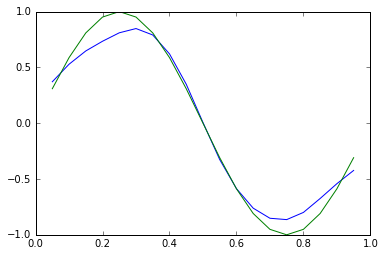

In [18]:
plt.plot(discretisation_points, np.mean(samples[5000:], axis=0))
plt.plot(discretisation_points, np.sin(2*np.pi*discretisation_points))

# Parametric Diffusivity

Now we consider the harder problem of solving the canonical elliptic PDE with an unknown diffusivity coefficient. Explicitly, this is the forward model from which the data is generated:

$$
\nabla \cdot \kappa(x) \nabla u(x) = \sin(2\pi x) \qquad \textrm{in } D \\
u(x) = 0 \qquad \textrm{on } \partial D
$$

where $\kappa(x) = \sin(2\pi x)$, but we treat this as unknown. So far as I know this problem does not have an explicit solution, so the true solution is generated using the Finite Element Method with a fine mesh.

We will start by using RWM with a parametric form for $\kappa$; we will say $\kappa(x) = \theta \sin(2\pi x)$ and attempt to infer $\theta$

In [19]:
data = np.loadtxt('data_simple')
data_points = data[:,0][:,None]
data_vals = data[:,1][:,None]

In [20]:
theta_1 = sp.symbols('theta_1')
A_np = NamedLambda(lambda k: (sp.exp(theta_1*sp.sin(2*sp.pi*x)) * k.diff(x)).diff(x), 'A')
Abar_np = NamedLambda(lambda k: (sp.exp(theta_1*sp.sin(2*sp.pi*y))*k.diff(y)).diff(y), 'Abar')
B_np = NamedLambda(lambda k: k, 'B')
Bbar_np = B_np

ops = [A_np,B_np]
ops_bar = [Abar_np, Bbar_np]

op_cache = bpdes.operator_caching.generate_op_cache(ops, ops_bar, k, [[x], [y], [theta_1]])

In [21]:
bdy_vals = np.array([[0.], [0.]])

In [22]:
def get_posterior(thetas):
    rhs = np.sin(2*np.pi*collocate_points)
    obs = [(collocate_points, rhs), (bdy_points, bdy_vals)]
    posterior = bpdes.collocate(ops, ops_bar, None, None, obs, op_cache, fun_args=[thetas])
    return posterior

def log_likelihood(theta):
    posterior = get_posterior(np.array([theta]))
    mu, cov = posterior(data_points)
    log_lik = stats.multivariate_normal.logpdf(mu.ravel(), data_vals.ravel(), cov + likelihood_sigma**2*np.eye(cov.shape[0]))
    return log_lik

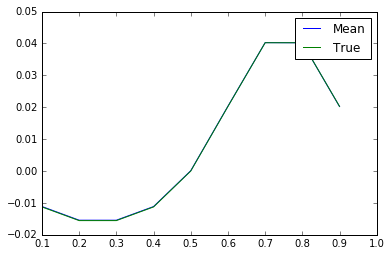

In [23]:
p = get_posterior(np.array([1.0]))
mu, cov = p(data_points)
plt.plot(data_points, mu, label='Mean')
plt.plot(data_points, data_vals, label='True')
plt.legend()

In [24]:
log_likelihood(1.0)

31.987217852859548

In [25]:
t = np.linspace(0,2,101)
liks = np.array([log_likelihood(tval) for tval in t])

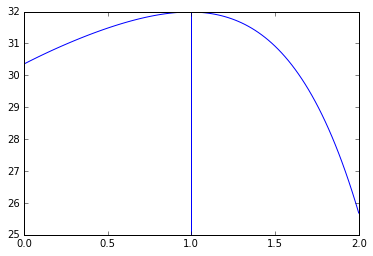

In [26]:
plt.plot(t, liks)
plt.axvline(1.)

In [27]:
# now MCMC

proposal_sigma = 0.5
cur_theta = 0.
samples = mcmc.rwm(5000, proposal, log_likelihood, lambda x: 0., cur_theta)

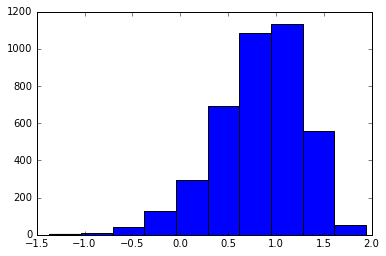

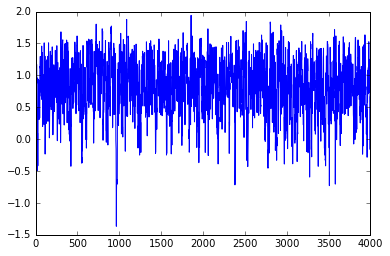

In [28]:
burn = 1000
thinned_burned = samples[burn:]
plt.hist(thinned_burned)
plt.figure()
plt.plot(thinned_burned)

# Nonparametric Diffusivity

Now we treat $\kappa(x)$ as unknown and endow it with a log-Gaussian prior.

In [29]:
data = np.loadtxt('data_simple')
data_points = data[:,0][:,None]
data_vals = data[:,1][:,None]
bdy_vals = np.array([[0.], [0.]])
kappa_0 = np.concatenate([np.sin(2*np.pi*discretisation_points), 2*np.pi*np.cos(2*np.pi*discretisation_points)])

I need my MCMC to run over both the function and its gradient now.

In [30]:
# First set up the covariance
prop_kernel = k
prop_A = lambda k: k
prop_B = lambda k: k.diff(x)
prop_Abar = prop_A
prop_Bbar = lambda k: k.diff(y)

prop_ops = [prop_A, prop_B]
prop_ops_bar = [prop_Abar, prop_Bbar]
prop_oc = bpdes.operator_caching.generate_op_cache(prop_ops, prop_ops_bar, prop_kernel, [[x], [y]])

prop_K = bpdes.collocation.calc_LLbar(prop_ops, prop_ops_bar, ((discretisation_points, None), (discretisation_points, None)), prop_oc)

In [31]:
A_1 = NamedLambda(lambda k: k.diff(x), 'A_1')
A_2 = NamedLambda(lambda k: k.diff(x, x), 'A_2')
A_1_bar = NamedLambda(lambda k: k.diff(y), 'A_1_bar')
A_2_bar = NamedLambda(lambda k: k.diff(y, y), 'A_2_bar')

tmp_oc = bpdes.operator_caching.generate_op_cache([A_1,A_2,B_np], [A_1_bar, A_2_bar,Bbar_np], k, [[x], [y]])

In [32]:
A_trans = A_np
A_bar_trans = Abar_np

class TransformedOpCache(object):
    def __init__(self, op_cache, kappa, grad_kappa):
        self.__op_cache__ = op_cache
        self.__kappa__ = kappa
        self.__grad_kappa__ = grad_kappa
    
    def __getitem__(self, item):
        return do_transform(item, self.__op_cache__, self.__kappa__, self.__grad_kappa__)

def do_transform(item, op_cache, kappa, grad_kappa):
    kappa = kappa.reshape((len(kappa), 1))
    grad_kappa = grad_kappa.reshape((len(grad_kappa),1))
    all_things = [()]
    
    # first explode out the objects required
    for i in item:
        if i == A_trans:
            all_things = sum([[a + (A_1,), a + (A_2,)] for a in all_things], [])
        elif i == A_bar_trans:
            all_things = sum([[a + (A_1_bar,), a + (A_2_bar,)] for a in all_things], [])
        else:
            all_things = [a + (i,) for a in all_things]

    def __calc_result(x,y):
        result = 0
        for item in all_things:
            try:
                function = op_cache[item]
            except Exception as ex:
                print 'Failed to get {}'.format(item)
                raise ex
            new_mat = function(x,y)
            if A_1 in item:
                #print 'A_1'
                new_mat = np.repeat(grad_kappa*np.exp(kappa),y.shape[0],1) * new_mat
            elif A_2 in item:
                #print 'A_2'
                new_mat = np.repeat(np.exp(kappa),y.shape[0],1) * new_mat
            if A_1_bar in item:
                #print 'A_1_bar'
                new_mat = np.repeat(grad_kappa.T*np.exp(kappa.T),x.shape[0],0) * new_mat
            elif A_2_bar in item:
                #print 'A_2_bar'
                new_mat = np.repeat(np.exp(kappa.T),x.shape[0],0) * new_mat
            result += new_mat
        return result
    return __calc_result

In [33]:
#tmp_oc_1 = CachedOpCache(tmp_oc)
oc = TransformedOpCache(tmp_oc, kappa_0[:n_discretisation], kappa_0[n_discretisation:])

In [34]:
likelihood_sigma = 0.01
def get_posterior(kappa, grad_kappa):
    rhs = np.sin(2*np.pi*collocate_points)
    obs = [(collocate_points, rhs), (bdy_points, bdy_vals)]
    oc = TransformedOpCache(tmp_oc, kappa, grad_kappa)
    posterior = bpdes.collocate([A_trans, B_np], [A_bar_trans, Bbar_np], None, None, obs, oc)
    return posterior

def phi(theta):
    kappa = theta[:len(discretisation_points), :]
    grad_kappa = theta[len(discretisation_points):, :]
    posterior = get_posterior(kappa, grad_kappa)
    mu, cov = posterior(data_points)
    cov_with_err = cov + likelihood_sigma**2*np.eye(cov.shape[0])
    cov_with_err_inv = np.linalg.inv(cov_with_err)
    cov_with_err_det = np.linalg.det(cov_with_err)
    delta = (mu.ravel()-data_vals.ravel()).reshape((len(mu), 1))
    return 0.5*np.log(cov_with_err_det) + (delta.T.dot(cov_with_err_inv).dot(delta)).item()
    
    #log_lik = stats.multivariate_normal.logpdf(mu.ravel(), data_vals.ravel(), cov + likelihood_sigma**2*np.eye(cov.shape[0]))
    #return -log_lik

In [35]:
sp.sin(2*sp.pi*x).diff(x)

2*pi*cos(2*pi*x)

In [36]:
def compare(k, x, y): 
    orig = op_cache[k](x, y, np.array([1.0]))
    new = oc[k](x, y)
    np.testing.assert_allclose(orig, new, atol=1e-12)
    
compare((A_np, Abar_np), discretisation_points, discretisation_points)
compare((A_np, Bbar_np), discretisation_points, discretisation_points)
compare((B_np, Abar_np), discretisation_points, discretisation_points)
compare((B_np, Bbar_np), discretisation_points, discretisation_points)
compare((A_np, ), discretisation_points, discretisation_points)
compare((B_np, ), discretisation_points, discretisation_points)
compare((Abar_np, ), discretisation_points, discretisation_points)
compare((Bbar_np, ), discretisation_points, discretisation_points)
compare((), discretisation_points, discretisation_points)

In [37]:
phi(kappa_0)

-40.25755600697822

In [38]:
beta = 0.5
proposal = mcmc.pcn.proposal(beta, prop_K)

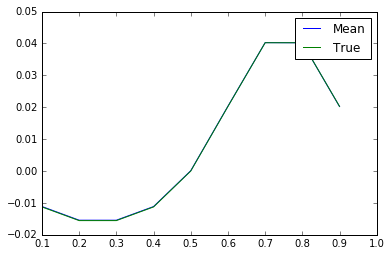

In [39]:
p_base = get_posterior(kappa_0[:n_discretisation], kappa_0[n_discretisation:])
mu_base, cov_base = p_base(data_points)
plt.plot(data_points, mu_base, label='Mean')
plt.plot(data_points, data_vals, label='True')
plt.legend()

In [40]:
mu_base

array([[ -1.11268125e-02],
       [ -1.54197056e-02],
       [ -1.54260741e-02],
       [ -1.11474760e-02],
       [  9.73483899e-05],
       [  2.03375075e-02],
       [  4.02701470e-02],
       [  4.02235180e-02],
       [  2.02139221e-02]])

In [42]:
#kappa_0 = np.concatenate([np.ones_like(discretisation_points), np.zeros_like(discretisation_points)])
samples = mcmc.pcn.pCN(int(1e5), proposal, phi, kappa_0)

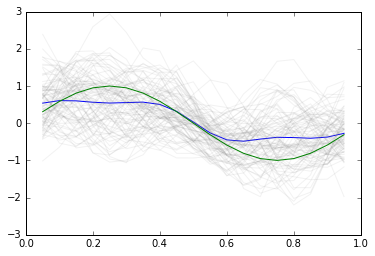

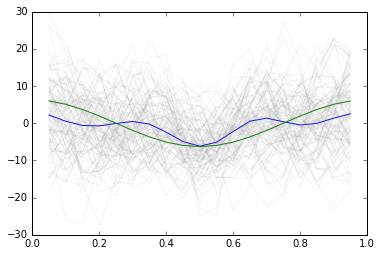

In [56]:
burn = int(1e4)
thinned_burned = samples[burn:,:]
kappa_tb = thinned_burned[:, :len(discretisation_points)]
grad_kappa_tb = thinned_burned[:, len(discretisation_points):]

plt.plot(discretisation_points, kappa_tb.mean(axis=0))
plt.plot(discretisation_points, kappa_tb[::1000].T, c='gray', alpha=0.1)
plt.plot(discretisation_points, np.sin(2*np.pi*discretisation_points))
plt.figure()
plt.plot(discretisation_points, grad_kappa_tb.mean(axis=0))
plt.plot(discretisation_points, np.cos(2*np.pi*discretisation_points)*2*np.pi)
plt.plot(discretisation_points, grad_kappa_tb[::1000].T, c='gray', alpha=0.1);

In [57]:
print phi(thinned_burned.mean(axis=0)[:,None])
print phi(thinned_burned[-1,:][:,None])
print phi(kappa_0)

-39.6299230967
-37.7160836501
-40.257556007


In [58]:
p_base = get_posterior(kappa_0[:n_discretisation], kappa_0[n_discretisation:])
p = get_posterior(thinned_burned[-1,:n_discretisation], thinned_burned[-1,n_discretisation:])

In [59]:
mu_base, cov_base = p_base(data_points)
mu, cov = p(data_points)

In [60]:
phi(thinned_burned[-1,:][:,None])

-37.71608365010038

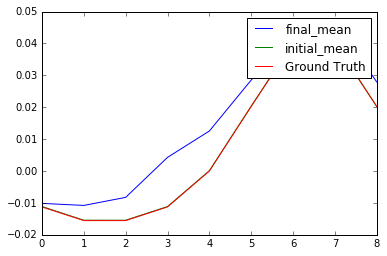

In [61]:
plt.plot(mu, label='final_mean')
plt.plot(mu_base, label='initial_mean')
plt.plot(data_vals, label='Ground Truth')

plt.legend()

In [49]:
adj_cov = cov + likelihood_sigma**2*np.eye(len(data_vals))
norm = - 0.5*np.log(np.linalg.det(adj_cov))
data_fit = -(mu-data_vals).T.dot(np.linalg.inv(adj_cov)).dot(mu-data_vals).item()
print data_fit, norm, data_fit + norm

-2.60297779372 40.3190614438 37.7160836501


In [62]:
adj_cov_base = cov_base + likelihood_sigma**2*np.eye(len(data_vals))
data_fit_base = -(mu_base-data_vals).T.dot(np.linalg.inv(adj_cov_base)).dot(mu_base-data_vals).item()
norm_base = - 0.5*np.log(np.linalg.det(adj_cov_base))
print data_fit_base, norm_base, data_fit_base + norm_base

-0.000217290907579 40.2577732979 40.257556007


In [63]:
(mu_base-data_vals).T.dot(mu_base-data_vals)

array([[  7.75325891e-08]])

In [64]:
(mu - data_vals).T.dot(mu - data_vals)

array([[ 0.00065539]])

In [65]:
phi(kappa_0)

-40.25755600697822